# Определение перспективного тарифа для телеком-компании
Имеются данные компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.  
В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**  

*Тариф «Смарт»*  
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.  

*Тариф «Ультра»*  
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.  

**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Содержание**
1. [Изучение данных из файла](#start)
2. [Предобработка данных](#preprocessing)
3. [Анализ данных и проведение расчетов](#analytics)
4. [Проверка гипотез](#check)
5. [Общий вывод](#conclusion)

## Изучение данных из файла 
<a id="start"></a>

In [ ]:
#загружаем нужные бибилиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import datetime as dt
from scipy import stats as st

In [ ]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [ ]:
calls.head(15)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [ ]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Таблица `Calls` содержит информацию о звонках: всего 202607 значений, пропущенных нет.

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [ ]:
internet.head(15)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [ ]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Таблица `internet` содержит информацию об интернет-сессиях: всего 149396 значений, пропущенных нет.

In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
messages.head(15)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Таблица `messages` содержит информацию о сообщениях: всего 123036 значений, пропущенных нет.

In [ ]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [ ]:
tariffs.head(15)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица `tariffs` содержит информацию о тарифах: всего 2 значения, пропущенных нет.

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
users.head(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [ ]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Таблица `users` содержит информацию о пользователях: всего 500 значений, пропущенные - есть в столбце `churn_date`(дата прекращения пользования тарифом) Это значит, что тариф ещё действовал на момент выгрузки данных.

**Вывод:**  
Предоставленные данные не содержат пропущенных значений, за исключением столбца `churn_date` в таблице `users`, что является хорошей новостью для компании, т.к. означает,что большинство пользователей продолжают пользоваться их тарифами.  
Во всех таблицах, где есть информация о дате, ее необходимо перевести в формат `date_time`.  

### Обработка данных в таблице users

In [ ]:
#Приведем данные в столбцах с датой в корректный формат
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')

In [ ]:
#Сразу создадим столбец, где приведем дату в месяц(необходим для дальнейших расчетов):
users['month'] = users['reg_date'].dt.month

In [ ]:
#Проверим на дубликаты
users.duplicated().sum()

0

### Обработка данных в таблице calls

In [ ]:
#Приведем данные в столбцах с датой в корректный формат
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')

In [ ]:
#Сразу создадим столбец, где приведем дату в месяц(необходим для дальнейших расчетов):
calls['month'] = calls['call_date'].dt.month

In [ ]:
#Проверим на дубликаты
calls.duplicated().sum()

0

In [ ]:
#Округлим значения продолжительности звонков вверх
calls.duration = calls.duration.apply(np.ceil).astype('int')

### Обработка данных в таблице messages

In [ ]:
#Приведем данные в столбцах с датой в корректный формат
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')

In [ ]:
#Сразу создадим столбец, где приведем дату в месяц(необходим для дальнейших расчетов):
messages['month'] = messages['message_date'].dt.month

In [ ]:
#Проверим на дубликаты
messages.duplicated().sum()

0

### Обработка данных в таблице  internet

In [ ]:
#Приведем данные в столбцах с датой в корректный формат
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')

In [ ]:
#Сразу создадим столбец, где приведем дату в месяц(необходим для дальнейших расчетов):
internet['month'] = internet['session_date'].dt.month

In [ ]:
#Проверим на дубликаты
internet.duplicated().sum()

0

**Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя**

In [ ]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [ ]:
#Создадим сводную таблицу 
users_calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc={'count', 'sum'})

In [ ]:
#Переименуем колонки для удобства
users_calls.columns = ['duration_count', 'duration_sum']

In [ ]:
users_calls.head(10)

duration_count  duration_sum
user_id month                              
1000    5                  22           159
        6                  43           172
        7                  47           340
        8                  52           408
        9                  58           466
        10                 57           350
        11                 43           338
        12                 46           333
1001    11                 59           430
        12                 63           414

In [ ]:
users_calls.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
duration_count    3174 non-null int64
duration_sum      3174 non-null int64
dtypes: int64(2)
memory usage: 62.9 KB


**Посчитаем количество отправленных сообщений по месяцам**

In [ ]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [ ]:
#Создадим сводную таблицу 
users_messages = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')

In [ ]:
#Переименуем колонку для удобства
users_messages.columns = ['messages']

In [ ]:
users_messages.head(10)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11

In [ ]:
users_messages.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2717 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
messages    2717 non-null int64
dtypes: int64(1)
memory usage: 32.7 KB


**Посчитаем для каждого пользователя по месяцам объем израсходованного интернет-трафика**

In [ ]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


In [ ]:
#Создадим сводную таблицу 
users_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')

In [ ]:
#перевожу в гб
users_internet['mb_used'] = users_internet['mb_used']/1024

In [ ]:
#округлю до большего значения
users_internet['mb_used'] = users_internet['mb_used'].apply(np.ceil).astype('int')

In [ ]:
#Переименую столбец
users_internet.rename(columns={'mb_used':'gb_used'}, inplace ='True')

In [ ]:
users_internet.head(10)

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
        10          15
        11          15
        12          10
1001    11          18
        12          14

In [ ]:
users_internet.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
gb_used    3203 non-null int64
dtypes: int64(1)
memory usage: 38.5 KB


<div class="alert alert-info"> 
    Так как я перевела значения в гигабайты, то и в таблице с тарифами надо заменить значения мегабайт на гигабайты<div>


In [ ]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
#Перевожу в гб
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
#Меняю название колонки
tariffs.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True)

In [ ]:
tariffs.head()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


**Посчитаем помесячную выручку с каждого пользователя**

*Объединим все сводные таблицы в одну, предварительно сбросив индексы*

In [ ]:
users_calls.reset_index(inplace=True)
users_internet.reset_index(inplace=True)
users_messages.reset_index(inplace=True)

In [ ]:
grouped_data = users_calls.merge(users_messages, how='outer', on=['user_id', 'month'])

In [ ]:
grouped_data

,user_id,month,duration_count,duration_sum,messages
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0
...,...,...,...,...,...
3208,1489,8,NaN,NaN,17.0
3209,1489,9,NaN,NaN,32.0
3210,1489,10,NaN,NaN,21.0
3211,1489,11,NaN,NaN,20.0


In [ ]:
grouped_data = grouped_data.merge(users_internet, how='outer', on=['user_id', 'month'])

In [ ]:
grouped_data

,user_id,month,duration_count,duration_sum,messages,gb_used
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17.0
3210,1489,10,NaN,NaN,21.0,20.0
3211,1489,11,NaN,NaN,20.0,18.0
3212,1489,12,NaN,NaN,35.0,17.0


В ходе объединения таблиц, в некоторых колонках появились отсутствующие значения, т.к. пользователь,например, не пользовался интернетом, не писал смс и т.д. Заменим их на ноль.

In [ ]:
grouped_data = grouped_data.fillna(0)

In [ ]:
grouped_data

,user_id,month,duration_count,duration_sum,messages,gb_used
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0
...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17.0
3210,1489,10,0.0,0.0,21.0,20.0
3211,1489,11,0.0,0.0,20.0,18.0
3212,1489,12,0.0,0.0,35.0,17.0


In [ ]:
#Объединим данные о пользователях с информацией о тарифах.
users_new = users.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date', 'month'], axis = 1)
users_new.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


In [ ]:
data = grouped_data.merge(users_new, on='user_id', how='left')

In [ ]:
data

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17.0,Санкт-Петербург,smart
3210,1489,10,0.0,0.0,21.0,20.0,Санкт-Петербург,smart
3211,1489,11,0.0,0.0,20.0,18.0,Санкт-Петербург,smart
3212,1489,12,0.0,0.0,35.0,17.0,Санкт-Петербург,smart


In [ ]:
#Выведем исходную таблицу с тарифами
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


In [ ]:
#Так как названия колонок с тарифом отличны, переименуем столбец
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)

In [ ]:
all_data = data.merge(tariffs,how='left', on='tariff')

In [ ]:
all_data.head(5)

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1


In [ ]:
len(all_data['user_id'].unique())

498

Для расчете помесячной выручки необходимо:
 - вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
 - остаток умножить на значение из тарифного плана; 
 - прибавить абонентскую плату, соответствующую тарифному плану.

In [ ]:
# Стоимость потраченных минут
all_data['cost_calls'] = (all_data['duration_sum'] - all_data['minutes_included'])*all_data['rub_per_minute']
all_data.head()

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,cost_calls
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2841.0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2828.0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2660.0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2592.0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2534.0


In [ ]:
# Стоимость потраченных сообщений
all_data['cost_msg'] = (all_data['messages'] - all_data['messages_included'])*all_data['rub_per_message']
all_data.head()

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,cost_calls,cost_msg
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2841.0,-978.0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2828.0,-940.0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2660.0,-925.0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2592.0,-919.0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2534.0,-943.0


In [ ]:
# Стоимость потраченных мегабайт
all_data['cost_gb'] = (all_data['gb_used'] - all_data['gb_per_month_included'])  * all_data['rub_per_gb']
all_data.head()

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,cost_calls,cost_msg,cost_gb
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2841.0,-978.0,-4050.0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2828.0,-940.0,-1050.0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2660.0,-925.0,-2400.0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2592.0,-919.0,-2400.0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,-2534.0,-943.0,-2250.0


Полученные отрицательные значения означают, что клиент не воспользовался услугой и следовательно не понес дополнительных расходов, поэтому заменим данные значения на ноль.

In [ ]:
num_to_null = all_data._get_numeric_data()
num_to_null[num_to_null < 0] = 0
all_data.head()

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,cost_calls,cost_msg,cost_gb
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0


<div class="alert alert-success">
<font size="5"<b>Комментарий ревьюера</b> </font>
    
**Успех**

Молодец, что не упустила этот момент
    
</div>

In [ ]:
# Рассчитаем столбец "выручка"
all_data['revenue'] = (all_data['cost_calls'] + all_data['cost_msg'] + all_data['cost_gb'] + all_data['rub_monthly_fee'])
all_data.tail(30)  

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,cost_calls,cost_msg,cost_gb,revenue
3184,1106,6,0.0,0.0,30.0,20.0,Калуга,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3185,1106,7,0.0,0.0,24.0,22.0,Калуга,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3186,1106,8,0.0,0.0,25.0,19.0,Калуга,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3187,1106,9,0.0,0.0,23.0,22.0,Калуга,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3188,1106,10,0.0,0.0,33.0,14.0,Калуга,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3189,1106,11,0.0,0.0,29.0,21.0,Калуга,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3190,1106,12,0.0,0.0,24.0,19.0,Калуга,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3191,1231,5,0.0,0.0,55.0,11.0,Чебоксары,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3192,1231,6,0.0,0.0,201.0,28.0,Чебоксары,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3193,1231,7,0.0,0.0,211.0,28.0,Чебоксары,ultra,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


In [ ]:
#Отфоматируем итоговую таблицу
all_data.columns
cols = ['user_id', 'month', 'duration_count', 'duration_sum', 'messages',
       'gb_used', 'city', 'tariff', 'cost_calls', 'cost_msg', 'cost_gb', 'revenue']
all_data = all_data[cols]  
all_data.head()

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,cost_calls,cost_msg,cost_gb,revenue
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,0.0,0.0,0.0,1950.0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,0.0,0.0,0.0,1950.0


In [ ]:
all_data[['duration_count','duration_sum','messages','gb_used','cost_calls','cost_msg','cost_gb','revenue']] = all_data[['duration_count','duration_sum','messages','gb_used','cost_calls','cost_msg','cost_gb','revenue']].astype('int')

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 12 columns):
user_id           3214 non-null int64
month             3214 non-null int64
duration_count    3214 non-null int64
duration_sum      3214 non-null int64
messages          3214 non-null int64
gb_used           3214 non-null int64
city              3214 non-null object
tariff            3214 non-null object
cost_calls        3214 non-null int64
cost_msg          3214 non-null int64
cost_gb           3214 non-null int64
revenue           3214 non-null int64
dtypes: int64(10), object(2)
memory usage: 326.4+ KB


**Вывод:**  
Рассчитана помесячная выручка для каждого пользователя. В результате объединения данных из таблиц часть значений выручки получилась отрицательная, значит клиент использовал минуты, смс и траффик внутри своего тарифного пакета. Подобные значения для удобства были заменены на нулевые значения.

## Анализ данных и проведение расчетов
<a id="analytics"></a>

### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

In [ ]:
all_data_grouped = all_data.pivot_table(
    index=['tariff', 'month'],
    values=['duration_sum', 'messages', 'gb_used'],
    aggfunc={'duration_sum': 'sum',
             'messages': 'sum', 'gb_used': 'sum'}
)

In [ ]:
all_data_grouped

duration_sum  gb_used  messages
tariff month                                 
smart  1              6931      297       620
       2             17324      687      1397
       3             30034     1173      2453
       4             41119     1526      3443
       5             54618     2243      4762
       6             64885     2616      5478
       7             82079     3191      6784
       8             99045     3933      7905
       9            111439     4262      8746
       10           125284     4963      9927
       11           137544     5372     10768
       12           161275     6134     12130
ultra  1              3853      119       304
       2              7131      288       527
       3             18117      653      1195
       4             25191      933      1736
       5             34192     1298      2536
       6             40295     1591      3505
       7             49667     1866      4536
       8             54653     2097      5183
       9             62036     2213      6013
       10            68644     2468      7187
       11            72545     2654      7476
       12            82400     3022      8425

Количество оказанных услуг возрастает с каждым месяцем. Пользователи тарифа "Смарт" более активно используют услуги, что связано с более дешевыми тарифами.

### Посчитаем среднее, дисперсию и стандартное отклонение по месяцам для каждого тарифа

In [ ]:
users_info_var = all_data.pivot_table(
    index=['tariff'],
    values=['duration_sum', 'messages', 'gb_used'],
    aggfunc= (np.var)
)

In [ ]:
users_info_var

,duration_sum,gb_used,messages
tariff,,,
smart,36219.315784,33.028705,796.812958
ultra,100873.633397,97.091686,2285.266143


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
users_info_var

,duration_sum,gb_used,messages
tariff,,,
smart,"36,219.32",33.03,796.81
ultra,"100,873.63",97.09,"2,285.27"


In [ ]:
# составим сводную таблицу для расчета стандартного отклонения
users_info_std = all_data.pivot_table(
    index=['tariff'],
    values=['duration_sum', 'messages', 'gb_used'],
    aggfunc= np.std
)
# переименуем столбцы
users_info_std.columns = ['duration_std', 'gb_used_std', 'message_std']
users_info_std  # проверка

,duration_std,gb_used_std,message_std
tariff,,,
smart,190.31,5.75,28.23
ultra,317.61,9.85,47.80


In [ ]:
# составим сводную таблицу для расчета среднего
users_info_mean = all_data.pivot_table(
    index=['tariff'],
    values=['duration_sum', 'messages', 'gb_used'],
    aggfunc= ('mean')
)
# переименуем столбцы
users_info_mean.columns = ['duration_mean', 'gb_used_mean', 'message_mean']
users_info_mean  # проверка

,duration_mean,gb_used_mean,message_mean
tariff,,,
smart,417.93,16.33,33.38
ultra,526.62,19.49,49.36


<div class="alert alert-info">Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию, отклонение и среднее по сравнению с тарифом «Смарт». Поведение пользователей в рамках тарифа "Ультра" более разнообразно.<div>

### Построим графики

In [ ]:
ultra = all_data.query('tariff == "ultra"')

In [ ]:
smart = all_data.query('tariff == "smart"')

Text(0.5, 1.0, 'Распределение длительности звонков пользователей тарифа Ультра')

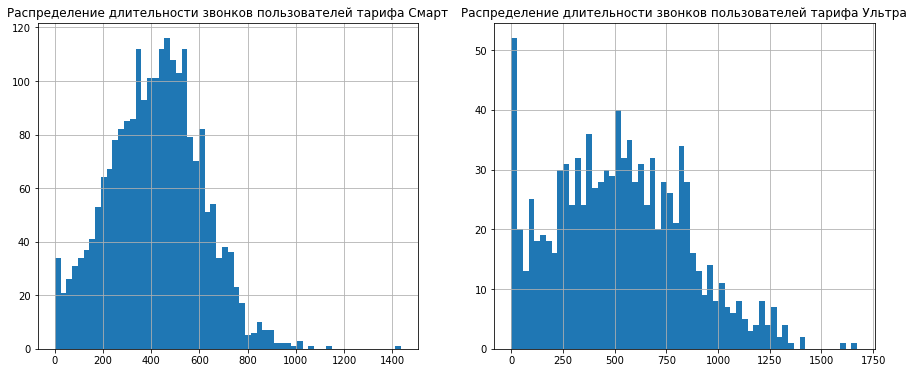

In [ ]:
#Построим гистограмму распределения длительности звонков по обоим тарифам
fig,axes = plt.subplots(1,2,figsize = (15,6))

smart['duration_sum'].hist(bins=60, ax = axes[0])
axes[0].set_title('Распределение длительности звонков пользователей тарифа Смарт')

ultra['duration_sum'].hist(bins=60, ax = axes[1])
axes[1].set_title('Распределение длительности звонков пользователей тарифа Ультра')

Text(0.5, 1.0, 'Распределение отправленных сообщений по тарифу Ультра')

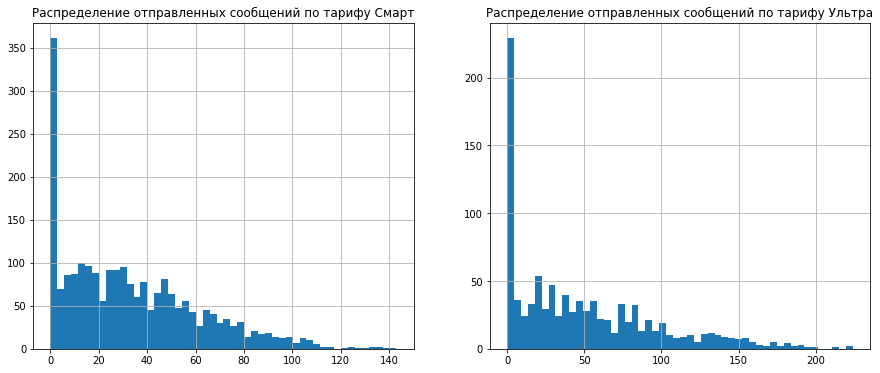

In [ ]:
#Построим гистограмму распределения отправленных сообщений по обоим тарифам
fig,axes = plt.subplots(1,2,figsize = (15,6))

smart['messages'].hist(bins=50, ax = axes[0])
axes[0].set_title('Распределение отправленных сообщений по тарифу Смарт')

ultra['messages'].hist(bins=50, ax = axes[1])
axes[1].set_title('Распределение отправленных сообщений по тарифу Ультра')

Text(0.5, 1.0, 'Распределение потраченных мегабайт по тарифу Ультра')

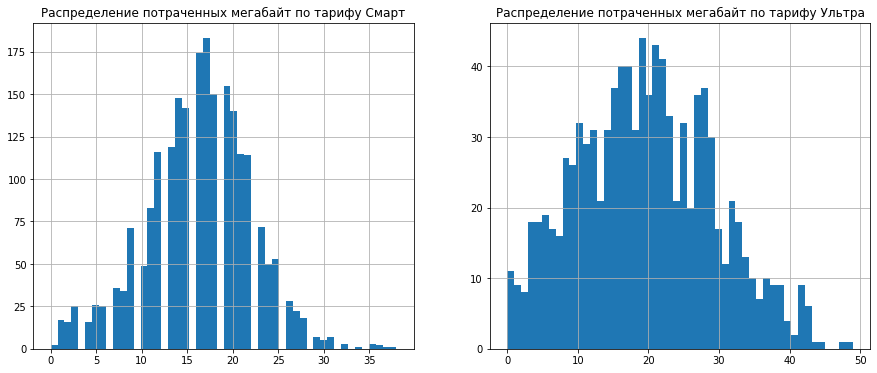

In [ ]:
#Построим гистограмму распределения потраченных мегабайт по обоим тарифам
fig,axes = plt.subplots(1,2,figsize = (15,6))

smart['gb_used'].hist(bins=50, ax = axes[0])
axes[0].set_title('Распределение потраченных мегабайт по тарифу Смарт')

ultra['gb_used'].hist(bins=50, ax = axes[1])
axes[1].set_title('Распределение потраченных мегабайт по тарифу Ультра')

<div class="alert alert-info"> Проверим пользователей тарифа "Смарт", которые явно переплачивают по тарифу. Т.к. оплата за тариф "Ультра" составляет 1950 рублей, выберем тех пользователей, которые платят больше данной суммы<div>


In [ ]:
#Фильтрую пользователей по заданному критерию выручки
users_over_tariff = smart.query('revenue >= 1950')

In [ ]:
#Оцениваю полученные значения
users_over_tariff.sort_values('revenue')

,user_id,month,duration_count,duration_sum,messages,gb_used,city,tariff,cost_calls,cost_msg,cost_gb,revenue
3168,1498,9,59,471,44,22,Владикавказ,smart,0,0,1400,1950
2225,1357,11,51,330,48,22,Томск,smart,0,0,1400,1950
2210,1355,8,48,349,14,22,Киров,smart,0,0,1400,1950
2135,1340,9,58,408,8,22,Пенза,smart,0,0,1400,1950
2129,1340,3,76,495,11,22,Пенза,smart,0,0,1400,1950
...,...,...,...,...,...,...,...,...,...,...,...,...
1793,1286,12,95,739,68,35,Москва,smart,717,54,4000,5321
1622,1261,12,141,1074,22,32,Казань,smart,1722,0,3400,5672
3105,1486,11,108,764,96,36,Нижний Новгород,smart,792,138,4200,5680
260,1042,12,121,728,75,37,Хабаровск,smart,684,75,4400,5709


**Итоги анализа поведения пользователей в зависимости от тарифа:**  
Пользователи дешевого тарифа "Смарт" суммарно потребляют услуг примерно в 1,5-2 раза больше, чем те кто пользуется тарифом "УЛЬТРА".  
Пользователи тарифа "УЛЬТРА" суммарно тратят меньше минут разговоров, но говорят дольше.  
Пользователи тарифа "УЛЬТРА" суммарно тратят больше мегабайт.  
Пользователи тарифа "УЛЬТРА", в среднем, в месяц, используют интернет больше чем "СМАРТ" пользователи.  
Пользователи тарифа "УЛЬТРА" и "СМАРТ" одинаково мало пользуются СМС, хотя последние немногим больше за счет массовости.

<div class="alert alert-info"> 471 человек значительно переплачивает по используемому тарифу и выгоднее будет перейти на другой тариф оператора.  
    В целом поведение пользователей тарифа "Ультра" более разнообразно, что вероятно связано с тем,что им не приходится думать об ограничениях на тарифе(что внезапно кончится весь запас интернета, не хватит звонков и тд) <div>


## Проверка гипотез
<a id="check"></a>

По заданию необходимо проверить две гипотезы

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

### Гипотеза 1: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

Исходя из формулировки гипотезы принимаем нулевую гипотезу H₀ как:
Средняя выручка пользователей тарифов "Ультра" и "Смарт" НЕ различаются

Уровень значимости (пороговое значение) установим как 5% 

In [ ]:
revenue_smart = all_data.loc[all_data['tariff']== 'smart', 'revenue']
revenue_smart.head()

8     1150
9      550
10     550
11    1150
12    1550
Name: revenue, dtype: int64

In [ ]:
revenue_ultra = all_data.loc[all_data['tariff']== 'ultra', 'revenue']
revenue_ultra.head()

0    1950
1    1950
2    1950
3    1950
4    1950
Name: revenue, dtype: int64

In [ ]:
#Проверяем гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"
alpha = 0.05  # уровень статистической значимости

results = st.ttest_ind(revenue_smart, revenue_ultra, equal_var=False)
print('p-значение:', results.pvalue)

# сравним получившееся p-значение с заданным уровнем статистической значимости
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


**Гипотеза верна - средние выручки двух тарифов различаются.**

### Гипотеза 2: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Исходя из формулировки гипотезы принимаем нулевую гипотезу H₀ как:
Cредняя выручка пользователей из Москвы и регионов НЕ различаются

Уровень значимости (пороговое значение) установим как 5% (как общепринятый параметр)

In [ ]:
revenue_moscow = all_data.loc[all_data['city'] == 'Москва', 'revenue']
revenue_moscow.head()

8     1150
9      550
17    1950
18    1950
19    1950
Name: revenue, dtype: int64

In [ ]:
revenue_other = all_data.loc[all_data['city']!= 'Москва', 'revenue']
revenue_other.head() 

0    1950
1    1950
2    1950
3    1950
4    1950
Name: revenue, dtype: int64

In [ ]:
alpha = 0.05  # уровень статистической значимости

results = st.ttest_ind(revenue_moscow, revenue_other, equal_var=False)
print('p-значение:', results.pvalue)

# сравним получившееся p-значение с заданным уровнем статистической значимости
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


**Нет подтвержения гипотезы 2. Мы не можем уверенно говорить о том что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

## Общий вывод
<a id="conclusion"></a>

На первом этапе исследования были рассмотрены предоставленные данные.  
Они достаточно корректные с минимальным количетсвом пропусков, что говорит об их достоверности.

На втором этапе исследования данные были обработаны: заменены типы, там где необходимо, округленые значения.
Дополнительно для каждого пользователя были рассчитаны и оформлены в сводные таблицы следующие параметры:

 - количество сделанных звонков и израсходованных минут разговора по месяцам;
 - количество отправленных сообщений по месяцам;
 - объем израсходованного интернет-трафика по месяцам;
 - помесячную выручка 

На третьем этапе исследования были рассчитаны такие показатели как среднее, дисперсия, стандартное отклонение.  Построены гистограммы по распределению длительности звонков, количеству отправленных сообщений и потраченных мегабайт.  
Проанализовано поведение пользовтелей в зависимости от тарифа:
 - Пользователи дешевого тарифа "Смарт" суммарно потребляют услуг примерно в 1,5-2 раза больше, чем те кто пользуется тарифом "УЛЬТРА".
 - Пользователи тарифа "УЛЬТРА" суммарно тратят меньше минут разговоров, но говорят дольше.
 - Пользователи тарифа "УЛЬТРА" суммарно тратят больше мегабайт.
 - Пользователи тарифа "УЛЬТРА", в среднем, в месяц, используют интернет больше чем "СМАРТ" пользователи.
 - Пользователи тарифа "УЛЬТРА" и "СМАРТ" одинаково мало пользуются СМС, хотя последние немногим больше за счет массовости.

На четвертом этапе были выдвинуты и проверены гипотезы о распределении выручки:
 - Средние выручки по двум тарифам различаются
 - Мы не можем уверенно говорить о том что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
